In [12]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List
from tqdm import tqdm
import os
import json
import random

import sentencepiece as spm

sp = spm.SentencePieceProcessor()
sp.load('spm_model.model')

text = "This is a sample sentence to tokenize."
tokens = sp.encode_as_pieces(text)
print(tokens)
print(sp.encode_as_ids(text))

['▁This', '▁is', '▁a', '▁sa', 'mp', 'le', '▁sentence', '▁to', '▁to', 'ken', 'ize', '.']
[102, 22, 14, 1693, 2265, 421, 7627, 6, 6, 4296, 3055, 3]


In [16]:

def load_emails(batch_size):
    dataset = []
    batch_counter = 0
    batch = []

    count = 0 #just to limit dataset size at first
    
    prefix = './PhishingEmails/' #change this to the prefile thing such as './celebA'

    for file in tqdm(os.listdir(prefix)):

        if count >= 200: #comment this out to get full data
            break
        
        with open(prefix + file) as jsonFile:
            jsonStr = jsonFile.read() #json file as a string
            email_dict = json.loads(jsonStr) #converts to dictionary

        
        setupData =  email_dict['email_subject'].strip() + ". " + email_dict['email_body'].strip()

        if batch_counter < batch_size:
            batch.append(setupData)
            batch_counter += 1
        else:
            dataset.append(batch)
            batch = []
            batch_counter = 0
       
    return np.array(dataset)

100%|██████████| 3332/3332 [00:00<00:00, 10003.21it/s]


['TREAT VERY CONFIDENTIAL & URGENT RESPONSES. From The Desk Of jerry kabore(Esq).The Head Of File Department,African Development Bank A.D.BOuagadougou Burkina-Faso West Africa.Phone: 00226-7885 75 97.\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 reply me with this email address jerry _kabore01@yahoo.com PLANE CRASH WEB SITE...http://news.bbc.co.uk/1/hi/world/europe/859479.stm\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 \xa0 ("REMITTANCE OF $15 MILLION U.S.A DOLLARS\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 \xa0CONFIDENTIAL IS THE CASE")Compliment Of The Season, On a very good day. I am (jerry kabore\xa0Esq),The Head of file Department in African developent bank (ADB).I got your contact from Yahoo tourist search.When i was searching for a foreign partner i assured of your capability and reliability to champion this businees opportunity when i praye

In [17]:
#Initialize helpful functions for math
def sigmoid(x: np.ndarray):
    return 1/(1+np.exp(-1*x))

def sigmoid_derivative(x: np.ndarray):
    return sigmoid(x)*(1-sigmoid(x))

def tanh(x: np.ndarray):
    return (np.exp(x) - np.exp(-x))/(np.exp(x)+np.exp(-x))
    
def tanh_derivative(x:np.ndarray):
    return 1-np.square(tanh(x))

def softmax(x: np.ndarray):
    return np.exp(x)/np.sum(np.exp(x))

def cross_entropy(yhat, y):
    loss = 0
     
    for i in range(len(yhat)):

        loss = loss + (-1 * y[i]*np.log(yhat[i]))
 
    return loss

In [27]:
#initializes the weights of the network
def initialize_cell(input_size, hidden_size):

    cell = {}

    cell["W_i"] = np.hstack((np.random.normal(0,1,(hidden_size,hidden_size)), np.random.normal(0,1,(input_size,hidden_size)))) #input gate weights
    cell["W_f"] = np.hstack((np.random.normal(0,1,(hidden_size,hidden_size)), np.random.normal(0,1,(input_size,hidden_size)))) #forget gate weights
    cell["W_c"] = np.hstack((np.random.normal(0,1,(hidden_size,hidden_size)), np.random.normal(0,1,(input_size,hidden_size)))) #candidate gate weights
    cell["W_o"] = np.hstack((np.random.normal(0,1,(hidden_size,hidden_size)), np.random.normal(0,1,(input_size,hidden_size)))) #output gate weights
    cell["W_y"] = np.hstack((np.random.normal(0,1,(hidden_size,hidden_size)), np.random.normal(0,1,(input_size,hidden_size)))) #final gate weights

    #not sure if the biases need to be 3d...
    cell["b_i"] = np.zeros(hidden_size,1) #input gate biases
    cell["b_f"] = np.zeros(hidden_size,1) #forget gate biases
    cell["b_c"] = np.zeros(hidden_size,1) #candidate gate biases
    cell["b_o"] = np.zeros(hidden_size,1) #output gate biases
    cell["b_y"] = np.zeros(hidden_size,1) #final gate biases

    return cell

In [28]:
#forward pass of all gates
def forward_pass(cell, prevA, prevC, X):
    
    input = np.concatenate(prevA, X)

    forward = {}

    forward["F"] = sigmoid(input.dot(cell["W_f"]).dot(input) + cell["b_i"])
    
    forward["C"] = tanh(input.dot(cell["W_c"]).dot(input) + cell["b_c"])

    forward["I"] = sigmoid(input.dot(cell["W_i"]).dot(input) + cell["b_i"])

    forward["O"] = sigmoid(input.dot(cell["W_o"]).dot(input) + cell["b_o"])

    forward["prevC"] = prevC
    forward["C_t"] = (forward["C_(t-1)"] * forward["F"]) + (forward["I"] * forward["C"])
    forward["A_t"] = forward["O"] * tanh(forward["C_t"])

    forward["Z_t"] = cell["W_y"].dot(forward["C_t"] * forward["O"]) + cell["b_y"]
    forward["Yhat"] = softmax(cell["Z_t"])

    return forward

In [29]:
def gradient(forward, cell, X, Y, lprimea, lprimec):

    grads = {}

    input = np.vstack(cell["prevA"], X)

    dldA_t = np.transpose(cell["W_y"]).dot(forward["Yhat"]-Y) + lprimea
    dldC_t = lprimec + (forward["O"] * tanh_derivative(forward["C_t"])) * dldA_t

    TdLdw_f = (dldC_t * forward["prevC"] * forward["F"]*(1-forward["F"])) #this might be slightly wrong, unsure.
    TdLdw_c = (dldC_t * forward["I"] * (1-np.square(forward["C"])))
    TdLdw_o = (dldA_t * forward["I"] * tanh(forward["C_t"]) * forward["O"] * (1-forward["O"]))
    TdLdw_i = (dldC_t * forward["C"] * forward["I"] * (1-forward["I"]))

    grads["dLdw_f"] = TdLdw_f.dot(np.transpose(input))
    grads["dLdw_c"] = TdLdw_c.dot(np.transpose(input))
    grads["dLdw_o"] = TdLdw_o.dot(np.transpose(input))
    grads["dLdw_i"] = TdLdw_i.dot(np.transpose(input))
    grads["dLdw_y"] = (forward["Yhat"] - Y).dot(np.transpose(forward["A_t"]))

    grads["dLdb_f"] = 1
    grads["dLdb_c"] = 1
    grads["dLdb_o"] = 1
    grads["dLdb_i"] = 1
    grads["dLdb_y"] = 1

    woa, _ = np.hsplit(cell["W_o"])
    wca, _ = np.hsplit(cell["W_c"])
    wia, _ = np.hsplit(cell["W_i"])
    wfa, _ = np.hsplit(cell["W_f"])
    
    grads["dLda_prev"] = woa * TdLdw_o + wca * TdLdw_c + wia* TdLdw_i + wfa * TdLdw_f
    grads["dLdc_prev"] = cell["O"] * (1-np.square(tanh(forward["C_t"])) * dldA_t + lprimec) * cell["F"]

    loss = cross_entropy(cell["Yhat"], Y)

    return grads, loss

In [30]:
def descent(cell, X, input_size, hidden_size, lr):
   
    prevA = np.zeros(hidden_size,1)
    prevC = np.zeros(hidden_size,1)
    lprimea = 0
    lprimec = 0

    gradientTot = {}
    lossTot = 0

    gradientTot["dLdw_f"] = np.hstack((np.random.normal(0,1,(hidden_size,hidden_size)), np.random.normal(0,1,(input_size,hidden_size))))
    gradientTot["dLdw_c"] = np.hstack((np.random.normal(0,1,(hidden_size,hidden_size)), np.random.normal(0,1,(input_size,hidden_size))))
    gradientTot["dLdw_o"] = np.hstack((np.random.normal(0,1,(hidden_size,hidden_size)), np.random.normal(0,1,(input_size,hidden_size))))
    gradientTot["dLdw_i"] = np.hstack((np.random.normal(0,1,(hidden_size,hidden_size)), np.random.normal(0,1,(input_size,hidden_size))))
    gradientTot["dLdw_y"] = np.hstack((np.random.normal(0,1,(hidden_size,hidden_size)), np.random.normal(0,1,(input_size,hidden_size))))
    gradientTot["dLdb_f"] = np.zeros(hidden_size,1)
    gradientTot["dLdb_c"] = np.zeros(hidden_size,1)
    gradientTot["dLdb_o"] = np.zeros(hidden_size,1)
    gradientTot["dLdb_i"] = np.zeros(hidden_size,1)
    gradientTot["dLdb_y"] = np.zeros(hidden_size,1)

    for i in range(1, len(X)-1):  #tqdm will create a loading bar for your loop

        curData = X[0:i]
        
        forward = forward_pass(cell, prevA, prevC, curData)
       
        gradient, loss = gradient(forward, cell, curData + X[i+1], curData + forward["Yhat"], lprimea, lprimec)
        lprimea = gradient["dLda_prev"]
        lprimec = gradient["dLdc_prev"]

        gradientTot["dLdw_f"] += gradient["dLdw_f"]
        gradientTot["dLdw_c"] += gradient["dLdw_c"]
        gradientTot["dLdw_o"] += gradient["dLdw_o"]
        gradientTot["dLdw_i"] += gradient["dLdw_i"]
        gradientTot["dLdw_y"] += gradient["dLdw_y"]
        
        gradientTot["dLdb_f"] += gradient["dLdb_f"]
        gradientTot["dLdb_c"] += gradient["dLdb_c"]
        gradientTot["dLdb_o"] += gradient["dLdb_o"]
        gradientTot["dLdb_i"] += gradient["dLdb_i"]
        gradientTot["dLdb_y"] += gradient["dLdb_y"]

        lossTot += loss

    cell["W_f"] = cell["W_f"] - gradientTot["dLdw_f"] * lr
    cell["W_c"] = cell["W_c"] - gradientTot["dLdw_c"] * lr
    cell["W_o"] = cell["W_o"] - gradientTot["dLdw_o"] * lr
    cell["W_i"] = cell["W_i"] - gradientTot["dLdw_i"] * lr
    cell["W_y"] = cell["W_y"] - gradientTot["dLdw_y"] * lr

    cell["b_f"] = cell["b_f"] - gradientTot["dLdb_f"] * lr
    cell["b_c"] = cell["b_c"] - gradientTot["dLdb_c"] * lr
    cell["b_o"] = cell["b_o"] - gradientTot["dLdb_o"] * lr
    cell["b_i"] = cell["b_i"] - gradientTot["dLdb_i"] * lr
    cell["b_y"] = cell["b_y"] - gradientTot["dLdb_y"] * lr

    return lossTot


In [31]:
def train_LSTM(input_size, hidden_size, dataset):

    cell = initialize_cell(input_size, hidden_size)

    losses = []

    for data in dataset:
        loss = descent(cell, data, input_size, hidden_size, 0.0001)
        losses.append(loss)

    return cell
    

In [32]:

batch_size = 16
dataset = load_emails(batch_size)

ex_email = dataset[random.randint(0, 50)]
print(ex_email)


vocab_size = 1000

hidden_size = 256
input_size = hidden_size + vocab_size

finalCell = train_LSTM(input_size, hidden_size, dataset)

  0%|          | 0/3332 [00:00<?, ?it/s]

100%|██████████| 3332/3332 [00:00<00:00, 9828.94it/s] 


['Re:. Deutsche bersetzung unten.\n-----------------------------\n\n SULE OKETAYO\n EAGLE BANK PLC\n suleoketayo@alexandria.cc\n \n\n Dear Sir/Madam,\n\n I am Sule Oketayo, the head of the Treasury Department of Foreign Operations Eagle Bank PLC of Nigeria.\n\n In my department, I discovered an abandoned sum of US$13,500,000.00  (Thirteen Million, Five Hundred Thousand United States Dollars) in an account belonging to one of our foreign customers who died along with his entire family in 1998 in an auto crash. This account was open with the bank in 1993 and since 1998 nobody has operated it. After careful investigation, I discovered that the owner of this account was the president of   MIRA CONSTRUCTION COMPANY LTD. Despite several attempts by the bank to trace the relatives/next of kin of the deceased, up to date nobody has yet come forward to claim the money.\n\nI later discovered that all his supposed next of kin died with him in the auto crash incident. I have spent the last five ye

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 256 and the array at index 1 has size 1256

3. After this you can put it together with your model to make your full *forward()* method, which will do a forward pass through your entire model (each layer, including the nonlinearities). It’s important to note that the final layer is not followed by a nonlinearity. You also must save every intermittent value in the cache (again for use later).

It is important to not only do the forward pass, but also cache the intermittent values so that we (well, *you* ) can do backpropogation next.

Use this code to test your backprop and loss function, this test is not extensive though, you should try more network sizes using your math

In [45]:
x = np.random.rand(3, 5)*0.9

# print()
# print("Single layer Network ----------------------------")
# print()

params = {"W0": np.random.rand(5,1), "b0": np.random.rand(1)}

your_pred, your_cache = forward(params, x)
# print(your_cache)
y = np.random.rand(3,1) 

your_grad, your_loss = backprop_and_loss(params, your_pred, your_cache, y)

print("your grad for W0:", your_grad["W0"])
print("correct grad for W0:", x.T.dot(2*(your_pred-y)))

# print("your loss:", your_loss)
# print("correct loss:", np.mean((your_pred-y)**2) )

params = {"W0": np.random.randn(5,4), "b0": np.zeros((4))}

params["W1"] = np.random.randn(4,2)
params["b1"] = np.zeros((2))

your_pred, your_cache = forward(params, x)
# print(your_cache)
y = np.random.rand(your_pred.shape[0],your_pred.shape[1]) 

print()
print("Now larger Network ----------------------------")
print()

your_grad, your_loss = backprop_and_loss(params, your_pred, your_cache, y)

print("your grad for W0:", your_grad["W0"])
print("your grad for W1:", your_grad["W1"])
#print("correct grad for W0:", x.T.dot(2*(your_pred-y)))

# print("your loss:", your_loss)
# print("correct loss:", np.mean((your_pred-y)**2) )



your grad for W0: [[1.47722818]
 [1.94281755]
 [2.17819972]
 [1.05121284]
 [1.70709924]]
correct grad for W0: [[1.47722818]
 [1.94281755]
 [2.17819972]
 [1.05121284]
 [1.70709924]]

Now larger Network ----------------------------

your grad for W0: [[-0.12930419  0.25562847  0.21567078  0.02922955]
 [-0.13911388  0.27461218  0.22273239  0.01330716]
 [-0.21457969  0.3644739   0.33975462 -0.01429388]
 [-0.11344546  0.16208002  0.16929955 -0.04171324]
 [-0.14651745  0.24768843  0.22581611 -0.02222018]]
your grad for W1: [[-1.29491158 -0.75953234]
 [-5.10970175 -3.43050998]
 [-4.56368491 -2.75302084]
 [-0.83895712 -0.44106145]]


6. Now it’s time to actually do the learning! You must complete the *gradient_descent()* method which will call all of your other methods to find first the prediction, then the loss and gradient. It will then use them to do gradient descent on the entire parameter dictionary (using the corresponding gradients). You’re free to do this however you see fit (as long as it works!)

In [46]:
def gradient_descent(X : np.ndarray, Y : np.ndarray, initial_params : dict, lr : float, num_iterations : int)->Tuple[List[float], np.ndarray]:
    """
    This function runs gradient descent for a fixed number of iterations on the
    mean squared loss for a linear model parameterized by the weight vector w.
    This function returns a list of the losses for each iteration of gradient
    descent along with the final weight vector.
    Parameters
    ----------
    X : np.ndarray
        A 2D numpy array representing input where each row represents a feature vector
    Y : np.ndarray
        A 1D numpy array where each element represents a label for MSE
    initial_params : dictionary
        A dictionary holding the initialization of all parameters of the model as np.ndarrays
        (e.g. key 'W0' maps to the first weight array of the neural net) 
    lr : float
        The step-size parameter to use with gradient descent.
    num_iterations : int
        The number of iterations of gradient descent to run.
    Returns
    -------
    losses : list
        A list of floats representing the loss from each iteration and the
        loss of the final weight vector
    final_params : dictionary 
        A dictionary holding all of the parameters after training as np.ndarrays
        (this should have the same mapping as initial_params, just with updated arrays) 
    """

    losses = []
    final_params = {}

    for n in tqdm(range(num_iterations)):  #tqdm will create a loading bar for your loop
        
        prediction, cache = forward(initial_params, X)

        gradient, loss = backprop_and_loss(initial_params, prediction, cache, Y)

        losses.append(loss)

        for i in range(0,len(initial_params)//2):

            initial_params["W" + str(i)] -= lr*gradient["W" + str(i)]
            initial_params["b" + str(i)] -= lr*gradient["b"+ str(i)]
    
    return losses, initial_params

7. Now you can run it! And once you fix the 1000 bugs that you have... you can run it again and hopefully you see something *somewhat* like below – if you do, congrats! You (probably) have it working:


Run both of these blocks and see if your graph looks similar

In [47]:
def learning_curve(losses: list, names : list):
    """
    This function plots the learning curves for all gradient descent procedures in this homework.
    The plot is saved in the file learning_curve.png. No TODO here
    Parameters
    ----------
    losses : list
        A list of arrays representing the losses for the gradient at each iteration for each run of gradient descent
    names : list
        A list of strings representing the names for each gradient descent method
    Returns
    -------
    nothing
    """
    for loss in losses:
        plt.plot(loss)
    plt.xscale("log")
    plt.ylim(0, 10000)
    plt.xlabel("Iterations")
    plt.ylabel("Squared Loss")
    plt.title("Gradient Descent")
    plt.legend(names)
    plt.savefig("learning_curve.png")
    plt.show()


(800, 17)


  9%|▊         | 859/10000 [00:00<00:01, 8088.86it/s]

100%|██████████| 10000/10000 [00:02<00:00, 3578.61it/s]


final training loss values
single layer.........   161.5
two layer............   154.7
many layer...........   160.7


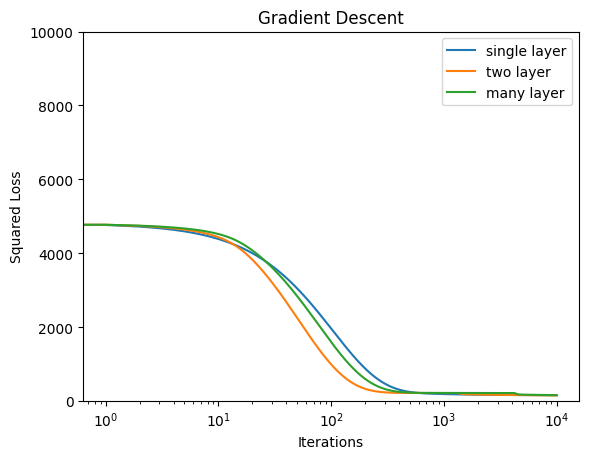

test loss of model 1: 105790.8732068747
test loss of model 2: 113569.83930553994
test loss of model 3: 124403.70111095396


100%|██████████| 10000/10000 [00:04<00:00, 2195.09it/s]

0.1011
test loss of your "best" model: 130367.64292079299


In [49]:
def train_networks():
    Train_X, Train_Y = load_data("StudentsPerformance.csv", "train")  # load the data set

    N = 10000 # N needs to equal 10,000 for your final plot. You can lower it to tune hyperparameters.
    print(Train_X.shape)

    init_params0 = initialize_network([17,3], scale=0.1) # initializes a sigle layer network (perceptron)
    losses0, final_params0 = gradient_descent(Train_X, Train_Y, init_params0, lr=1e-6, num_iterations=N)  

    init_params1 = initialize_network([17, 5, 3], scale=0.1)  # initializes a two layer network
    losses1, final_params1 = gradient_descent(Train_X, Train_Y, init_params1, lr=1e-6, num_iterations=N)  
   
    init_params2 = initialize_network([17, 7, 3, 3], scale=0.1)  # initializes a many layer network
    losses2, final_params2 = gradient_descent(Train_X, Train_Y, init_params2, lr=1e-6, num_iterations=N)   

    all_losses = [losses0, losses1, losses2]
    names = ["single layer", "two layer", "many layer"]
    print("final training loss values")
    for name, losses in zip(names, all_losses):
        print("{0:.<21}{1:>8.1f}".format(name, float(losses[-1])))

    learning_curve(all_losses, names)

    # TESTING 

    Test_X, Test_Y = load_data("StudentsPerformance.csv", "test")

    pred0, _ = forward(final_params0, Test_X)
    test_loss0 = np.sum(np.square(Test_Y  - pred0)) 
    print("test loss of model 1:", test_loss0)

    pred1, _ = forward(final_params1, Test_X)
    test_loss1 = np.sum(np.square(Test_Y  - pred1)) 
    print("test loss of model 2:", test_loss1)

    pred2, _ = forward(final_params2, Test_X)
    test_loss2 = np.sum(np.square(Test_Y  - pred2)) 
    print("test loss of model 3:", test_loss2)

    # TODO choose the hyper parameters for your best model (change them in train_best_model() )
    # You'll have to uncomment the below lines for once you find your best model

    best_losses, best_params = train_best_model(Train_X, Train_Y) 
    best_pred, _ = forward(best_params, Test_X)
    best_loss = np.sum(np.square(Test_Y - best_pred)) 
    print("test loss of your \"best\" model:", best_loss)


train_networks()

### 4a) That other bit you forgot about until now (10 points)
1. Use *train_best_model()* (you’ll need to find some good hyperparameters) and plot its training alongside the other 3 models (you’ll need to change code in main to plot this) and show it here – Describe your best model and list the values of its hyperparameters here. You should be able to do significantly better than the default, you will be checked for the code you used to find a best model and for the quality of your final loss.

In [48]:
def train_best_model(Train_X, Train_Y):
    """
    This function will train the model with the hyper parameters
    and layers that you have found to be best -- this model must get below 3
    MSE loss on our test data (which is not the test data you are given)
    """

    BEST_SCALE = 0.1011            # You need
    BEST_LAYERS = [17, 15, 3]          # to change
    BEST_ALPHA = 0.00001             # these
    BEST_NUM_ITERATIONS = 10000    # !


    best_params = initialize_network(BEST_LAYERS, BEST_SCALE)
    best_losses, best_final_params = gradient_descent(Train_X, Train_Y, best_params, lr=BEST_ALPHA, num_iterations=BEST_NUM_ITERATIONS)

    print(BEST_SCALE)
    return best_losses, best_final_params

Train_X, Train_Y = load_data("StudentsPerformance.csv", "train")  # load the data set  
best_losses,best_final_params = train_best_model(Train_X, Train_Y)

print("final loss:", best_losses[-1])     

  2%|▏         | 174/10000 [00:00<00:05, 1649.68it/s]

100%|██████████| 10000/10000 [00:04<00:00, 2109.62it/s]

0.1011
final loss: 133.28059750877068


2. Now note the printed test losses (the loss on the test set which isn’t trained on), for the 3 original models and your best, show the train loss and test loss. What is the relationship between these, explain why you think this is?

test loss of model 1: 105753.67332288889
test loss of model 2: 113589.8688507396
test loss of model 3: 121774.24686293973
test loss of your "best" model: 135425.31890427636

single layer.........   161.5
two layer............   154.8
many layer...........   164.2
final loss...........   132.2

The test loss seems inversely proportional to the train loss. 
This may be due to my best model overfitting, leading to poor generalization.

### 5) Time to Convert to PDF! (No Skipping this Step 🚀)

Hi! Congrats on finishing (or reading ahead)! We'll be using the google colab library to convert your notebook into a pdf, so you'll need to convert to colab if you're not using it (or finding another way to convert to a pdf):

📤 **Uploading to Colab from Your System? Here's How:**
1. Go to [colab](https://colab.research.google.com/).
2. Hit "upload" on the left sidebar of the pop-up box.
3. Upload the notebook.
4. It's alright if you've already run your code, the outputs of the cells should be brought over too.

🛣️ **Once you're on colab (or if you always were):**
1. First things first, click on File > Locate in Drive.
2. Next up, copy the path of the folder where your notebook resides in your Drive and paste it in variable named `DIR_FOR_COLAB_NOTEBOOK` in the cell below. (Usually, it's just 'Colab Notebooks/')
3. Next asisgn the variable named `NOTEBOOK_NAME` with the name of your notebook. Easy peasy!
4. Run the final cells
5. Double check the pdf has all of your code and outputs then slam that bad boy into gradescope.


In [33]:
DIR_FOR_COLAB_NOTEBOOK = 'Colab Notebooks/' #Please update it to the correct directory following the instruction
NOTEBOOK_NAME = 'HW2_notebook.ipynb' #Please update this to the name of the file you see on top right next to colab logo

In [34]:
import os
from google.colab import drive, files
import subprocess

assert DIR_FOR_COLAB_NOTEBOOK is not None, "Please update the variable DIR_FOR_COLAB_NOTEBOOK to the correct directory"
assert NOTEBOOK_NAME is not None, "Please update NOTEBOOK_NAME to correct notebook name"

print("\n#Mounting google drive\n")
drive.mount('/content/drive/')
notebook_dir = os.path.join('/content/drive/MyDrive', DIR_FOR_COLAB_NOTEBOOK)
os.chdir(notebook_dir)

print("\n#Installing Dependencies\n")
print("Installing nbconvert...", end="")
subprocess.run(f"pip install nbconvert", shell=True)
print("Done")
print("Installing texlive and dependancies...", end="")
subprocess.run(f"apt-get install texlive texlive-xetex texlive-latex-extra pandoc", shell=True)
print("Done")

print("\n#Converting to PDF\n")
print(f"Running the following command:\njupyter nbconvert --to pdf {NOTEBOOK_NAME} --output {NOTEBOOK_NAME.replace('.ipynb', '.pdf')}\n")
print("Started conversion...", end="")
result = subprocess.run(f"jupyter nbconvert --to pdf {NOTEBOOK_NAME} --output {NOTEBOOK_NAME.replace('.ipynb', '.pdf')}", shell=True, stderr=subprocess.PIPE)
print("Done")
print("\n##Output of conversion:\n")
print(result.stderr.decode())

print("\n#Downloading PDF file\n")
files.download(NOTEBOOK_NAME.replace('.ipynb', '.pdf'))

ModuleNotFoundError: No module named 'google'